# Classification example

The goal of this script is to illustrate classification of timeseries as being
generated by observing stable or unstable objects.  

For this, do the following:

    1. Definitions and imports
    2. Auxiliary functions
    3. Simulate the data and labels 
    4. Feature extraction
    5. Training the SVM
    6. Plots and illustrations

The following entries may be changed to explore the script:

    * sigma_noise , sigma_signal  : Both together define the signal-to-noise ration in the data
    * corr_length_signal  : A quantity describing how slow the correlation between values drops
                            depending on temporal separation. Increase to generate a smoother signal.
    * n_expansion         : Determines, how many expansion coefficients are constructed for each time series.
                            The classifier is then trained on the expansion coefficients. Can be either 2 or 3.
    * n_episodes          : The number of time series used for training and testing
    * decision_rule       : The rule for deciding if a timeseries is associated to a failure by
                            assigning decision_rule(timeseries)=1 or decision_rule(timeseries)=0.

                                                                        
This script is given out as part of the Machine Learning Tutorial during IV2020, Munich. Please consult the slides for some background information regarding motivation and a possible physical setup for this toy example.

Written by Jemil Butt, Zan Gojcic, ETH Zurich.



  # 1. Definitions and imports  ------------------------------------------------

The support vector machine to be constructed in the codeblocks below is supposed to take as input timeseries $x(\cdot)$ and output a prediction if those timeseries are associated to the measurement of a stable object or an instable object (movement in positive direction). To learn the relationship 

$$ \phi:X\ni x(\cdot)\mapsto \phi(x)=y \in \{0,1\}$$

between timeseries $x(\cdot)$ and instability as encoded by the binary quantity $y\in\{0,1\}$, labled sample data $\{(x_k,y_k)\}_{k=1}^n \in X\times Y$ is necessary. The way this sample data is generated can be controlled by specifying the smoothness of the underlying signal $(\rho_{signal}$) determining the stability and the signal-to-noise-ratio $(\sigma^2_{signal}/\sigma^2_{noise})$ determining the amount of completely non-indicative noise polluting whose superimposition with the signal forms the observations. The amount of labled timeseries data generated for training and test purposes can be adjusted by changing $n_{episodes}$.

The underlying rule for determining if a timeseries $x_k$ is associated to a stable $(y_k=0)$ or instable $(y_k=1)$ object is not known in practical applications and the dataset typically comes from compiling case examples to learn from. In this toy example we simulate the data and decide according to an automated underlying decision rule that is unknown to the classifier. It generates labels based on observed noisy timeseries $$x=x_{signal}+x_{noise}$$ by associating to $x$ the label "stable" or "instable" depending on $x_{signal}$ exceeding a certain threshold. The images below illustrate the type of the input data used to train the support vector machine.

Data episode 1 $\hspace{12cm}$ Data episode 2

![alt text](https://drive.google.com/uc?id=1m6EYi1pcuo7ZoQak__woiLdbS_aC-iM-)
Given only a sequence of noisy $x_k$'s and their corresponding labels $y_k$, the unknown rule for associating $y's$ to $x's$ is to be guessed and applied.

In [1]:

# 1.1 Import numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cvxopt
from sklearn.metrics import accuracy_score
import random
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import ListedColormap

# 1.2 Define the number of observations and the time at which they take place
#       (Time interval is arbitrarily set to [0,1] to avoid scaling issues)
n_timesteps = 100
time = np.linspace(0, 1, n_timesteps)

#1.3 Parameters for simulationa and estimation

# Parameters for simulation               # The following parameters may be changed to explore the method
sigma_noise = 0.1                         # Quantifies the average magnitude of the noise
sigma_signal = 1                          # Quantifies the average magnitude of the signal
corr_length_signal = 1                    # A quantity describing how slow the correlation between values drops
                                          # depending on temporal separation.
n_expansion = 2                           # The number of polynomials in the parametric regression
n_episodes = 500                          # The number of simulations on which the decision rule is based
decision_rule=lambda x: x[-1] >= 1.0      # The rule for deciding if a failure occured or not. It is here
                                          # fixed as comparing the temporally last state to a threshold.
                                          # This is unknown to the algorithm.
                                          # The following is a decision rule to check for two-sided movement:
                                          # decision_rule=lambda x: x[-1] >= 1.0 or x[-1]<=-1

print('Packages imported. The parameters for simulation and ground truth generation have been defined and are now \
ready for later use.')
                                          

Packages imported. The parameters for simulation and ground truth generation have been defined and are now ready for later use.


# 2. Auxiliary functions ----------------------------------------------------

Several special functions necessary for data management, embedding, and plotting are defined for later use. This section can be glossed over on first contact. Of course the code needs to be executed nonetheless!

In [2]:

# 2.1 Kernel-related functions

# Define the covariance functions of signal and noise for simulation
def cov_fun_signal(time_1, time_2, sigma_signal, corr_length):
    covariance = np.power(sigma_signal, 2) * np.exp(-np.power(((time_1 - time_2) / corr_length), 2))
    return covariance

# Define the kernel function for high dimensional embedding
def gaussian_kernel(x, y, sigma):
    return np.exp(- np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

# Define a function that creates kernel matrices
def initialize_gram_matrix(X, sigma=0):
    n_samples, n_features = X.shape
    K = np.zeros((n_samples, n_samples))

    if not sigma:
        sigma = 1 / n_features

    for i, x_i in enumerate(X):
        for j, x_j in enumerate(X):
            K[i, j] = gaussian_kernel(x_i, x_j, sigma)
    return K

# 2.2 SVM-construction-related functions
    
# Given a solution to the Optimization problem in 4., calculate the intercept 
# parameter of the svm
def calculate_intercept(lagr_mul, s_vector_labels, s_vectors):
    intercept = s_vector_labels[0]
    for i in range(len(lagr_mul)):
        intercept -= lagr_mul[i] * s_vector_labels[i] * gaussian_kernel(s_vectors[i],
                                                                        s_vectors[0], 1 / s_vectors.shape[1])
    return intercept

# Given a solution to the optimization problem in 4. and the intercept parameter,
# calculate the predicted class labels of all the observations accumulated in 
# matrix X.
def predict(X, lagr_mul, s_vector_labels, s_vectors, intercept):
    y_pred = []
    # Iterate through list of samples and make predictions
    for sample in X:
        prediction = 0
        # Determine the label of the sample by the support vectors
        for cnt in range(len(lagr_mul)):
            prediction += lagr_mul[cnt] * s_vector_labels[
                    cnt] * gaussian_kernel(s_vectors[cnt], sample, 1 / s_vectors.shape[1])

        prediction += intercept
        y_pred.append(np.sign(prediction))
    return np.array(y_pred)

# 2.3 Data management functions
    
# Split data into a training set teaching the algorithm the prediction rules
# and a test set used for evaluating the prediction qualities.
def train_test_split(X, y, test_size=0.2,shuffle=False):
    combined_array = np.concatenate((X, y),axis=1)
    dim = combined_array.shape[1] - 1
    if shuffle:
        np.random.shuffle(combined_array)

    n_test = int(X.shape[0] * test_size)
    split = np.asarray(random.sample(range(X.shape[0]), n_test))

    return combined_array[~split,0:dim], combined_array[split,0:dim], combined_array[~split,dim], combined_array[split, dim]

# 2.4 2D and 3D plotting-related functions
    
# From a pair of vectors create two matrices of coordinates that correspond to the 
# cartesian product of the coordinates such that xx enumerates all the x values 
# in a rectangle of size x X y and yy enumerates all the y values in a rectangle
# of size x X y. This is for plotting a field of predictions with extent x in x-direction
# and extent y in y-direction.
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

# From a triple of vectors create three tensors of coordinates that correspond to the 
# cartesian product of the coordinates such that xx, yy, and zz enumerate all the x,y,z values 
# in a 3d Hyperrectangle of size x X y X z . This is for plotting a field of predictions
# with extent x in x-direction, extent y in y-direction, and extent z in z-direction.
def make_meshgrid3(x, y,z, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    z_min, z_max = z.min() - 1, z.max() + 1
    xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h), np.arange(z_min, z_max, h))
    return xx, yy, zz

print('Auxiliary functions necessary for hyperplane construction and training successfully defined.')


Auxiliary functions necessary for hyperplane construction and training successfully defined.


# 3. Simulate the data and labels -------------------------------------------

Simulate randomly chosen smooth signals by considering them to be drawn from a multivariate Gaussian distribution with dimension $n_{timesteps}$. With e.g. $n_{timesteps}=100$, each throw of the dice produces a vector of length 100 that we interpret as a function mapping dimension indices to function values. We then draw $x_{signal}$ according to
$$ x_{signal}\sim\mathcal{N}(0,K)$$
where $0\in \mathbb{R}^{100}$ and $K\in \mathbb{R}^{100 \times 100}$. $\mathcal{N}$ symbolizes the multivariate Gaussian distribution. Even though each draw is random and the different realizations are independent of each other, there exists significant spatial correlation between neighboring values.  More explanations of the intuition behind the simulation process may be found in the notes associated to the regression example. Each of the simulated timeseries is then subjected to noise so that the observations finally passed as input to the support vector machine satisfy $$x=x_{signal}+x_{noise}.$$

Some exemplary training data associated to negative and positive case examples can be seen in the image below.

![alt text](https://drive.google.com/uc?id=1lsVMcgnOiAhL6bJjiKwDlDHkhb0ctojn)

Note that the decision rule classifying timeseries into the positive or negative class can be modified in section 1 if you want to alter it to something more sophisticated than just comparing the timeseries to a threshold.

In [3]:

# 3.1 Construct covariance matrices of signal - nontrivial, smooth correlation
Cov_mat_signal=np.zeros((n_timesteps,n_timesteps))
for i in range(n_timesteps):
    for j in range(n_timesteps):
        Cov_mat_signal[i,j]=cov_fun_signal(time[i],time[j],sigma_signal,corr_length_signal)
            
# 3.2 Construct covariance matrices of noise - uncorrelated, white noise
Cov_mat_noise =np.power(sigma_noise,2)*np.eye(n_timesteps)
        
# 3.3 Do the simulation 
x_true = np.zeros((n_timesteps,n_episodes))
x_measured = np.zeros((n_timesteps,n_episodes))

for k in range(n_episodes):
    # First simulate random signal ...
    x_true[:,k]=np.random.multivariate_normal(np.zeros([n_timesteps]),Cov_mat_signal)
    
    # ... then add noise to create the synthetic measurements
    x_measured[:,k]=x_true[:,k]+np.random.multivariate_normal(np.zeros([n_timesteps]),Cov_mat_noise)

# 3.4 Generate the labels
labels_true=np.zeros((n_episodes,1))
for k in range(n_episodes):
    labels_true[k,0]=decision_rule(x_true[:,k])

print('Covariance matrices have been constructed. Simulations were carried out by sampling from \
multivariate normal distributions and employing the decision rule.')
    

Covariance matrices have been constructed. Simulations were carried out by sampling from multivariate normal distributions and employing the decision rule.


# 4. Feature extraction -----------------------------------------------------

The features used to represent the timeseries $x$ are the regression coefficients $\alpha_1, \alpha_2$ of the best fit of a polynomial of degree $n_{expansion}=2$ to the timeseries $x_k$. To find these coefficients $\alpha$ solve the adjustment problem 
$$\alpha^*=\underset{\theta\in \Theta}{\operatorname{argmin}}\|A\alpha-b\|^2_2$$
where $\alpha=(\alpha_1,\alpha_2)$, $b$ is the data $\| \cdot\|_2$ is the 2-norm indicating sums-of-squares and $A$ is the design matrix with $(A)_{ij}=(t_i)^j$ and $t$ the time argument. As is well known, the solution is $\alpha^*=(A^TA)^{-1}A^Tb$.

It is possible to use more features by adjusting $n_{expansion}$ to $3$. Due to visualization purposes this is the maximum number of features allowed in this example. Each timeseries $x_k$ is subsequently represented by a two dimensional feature vector 

 $$feature(x_k)=(\alpha_1^k,\alpha_2^k).$$

Some exemplary features representing timeseries already colored in such a way as to indicate class membership are shown in the image below.

![alt text](https://drive.google.com/uc?id=1zlec3EtPqaFUDlcRf_Li7vNG7K5pAFca)

We embed these two-dimensional features into a higher dimensional space by replacing the feature $\alpha=(\alpha_1,\alpha_2)\in \mathbb{R}^2$ by $k(\alpha,\cdot)$ - an infinite sequence of powers in $\alpha_1$ and $\alpha_2$ indexed by a continuous argument. This is a quite broadly employable technique for handling nonlinearities and is usually called the 'kernel trick'.

In [5]:

# 4.1 Do a parametric regression to extract abscissa, slope, ... as the regression
# coefficients

# Preparation of design matrix
A = np.zeros((n_timesteps, n_expansion))
eye_mat = np.eye(n_expansion)
for k in range(n_expansion):
    Legendre_k = np.polynomial.legendre.Legendre(eye_mat[:,k])
    A[:,k]=Legendre_k(2*time-time[-1])
    
# Estimation via adjustment
coeffs_estimated = np.zeros((n_expansion, n_episodes))
x_estimated=np.zeros((n_timesteps, n_episodes))

for k in range(n_episodes):
    coeffs_estimated[:,k]=np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(A),A)),np.transpose(A)),x_measured[:,k]) 
    x_estimated[:,k]=A@coeffs_estimated[:,k] 

# 4.2 Preprocessing to simplify interpretation
coeffs_estimated = coeffs_estimated.T  # Transpose such that X in R^Nxk
gt_labels = np.ones((coeffs_estimated.shape[0], 1))    # Prepare the labels to be y in {-1,1}
gt_labels[np.where(labels_true != 0), 0] = -1

print('Abscissa and slope have been extracted from timeseries via Least Squares and are \
assigned as features representing this timeseries.')


Abscissa and slope have been extracted from timeseries via Least Squares and are assigned as features representing this timeseries.


# 5. Training the SVM -------------------------------------------------------

The simplest possible method to train a classifier would be to find the plane separating the features associated to the different classes. Typically this is not possible and one instead tries to find the plane minimizing the amount of misclassified examples and having the biggest distance to each of them. This is illustrated in the image below.

![alt text](https://drive.google.com/uc?id=18tlzNmsLRIctbCuIK6IQEg673gu4wu8e)

As indicated in section 4., the support vector machine goes one step further and embeds the 2-dimensional features into an infinite-dimensional Hilbert space $\mathcal{H}$ characterized by a kernel $k(\cdot,\cdot)$. The appropriate optimization formulation for finding the maximally discriminating hyperplane in that space is given by the problem of finding the optimal coefficients $\theta^*$ with 

$$\begin{align} \theta^* =&\underset{\theta \in \mathbb{R}^{n_{episodes}}}{\operatorname{argmin}}\frac{1}{2} \sum_{i=1}^{n_{episodes}}\sum_{j=1}^{n_{episodes}}y_iy_jk(\alpha_i,\alpha_j)\theta_i\theta_j - \sum_{i=1}^{n_{episodes}}\theta_i \\ &s.t. ~~~~~~~~~0\le \theta_i \le c ~~~\forall i\in \{1, ... ,n_{episodes}\}\\& ~~~~~~~~~~~~~~~~\sum_{i=1}^{n_{episodes}}\theta_iy_i=0\end{align}$$

where $c$ is a constant specifying the amount of allowed irregularity in the decision boundary. This is a quadratic program that can be solved for the parameters $\theta$ using numerical python packages such as CVX, a convex optimization package developed and maintained by Stanford university (see references in slides). The final decision rule is then given by 
$$\hat{y}=\operatorname{sign}\left(\sum_{j=1}^{n_{episodes}}\theta_jy_jk(\alpha_j,\alpha_j) + \frac{1}{n_{episodes}}\sum_{i=1}^{n_{episodes}}\left(y_i - \sum_{j=1}^{n_{episodes}}y_j\theta_jk(\alpha_i,\alpha_j)\right)\right).$$

More details can be found in Schoelkopf and Smola (1999), pp.203-209.

In [6]:

# 5.1. Prepare training step

# Split data into training and test set and initialize Kernel matrix
X_train, X_test, y_train, y_test = train_test_split(coeffs_estimated, gt_labels, test_size=0.2)
n_samples, n_features = X_train.shape
kernel_matrix = initialize_gram_matrix(X_train, 0.3)


# 5.2 execute training step by solving the following optimization problem using
# cvxopt convex optimization library.
# min 1/2 alpha^T Q alpha + e^T alpha 
# s.t.
#  0 <= alpha <= c
#  A * alpha = 0

# Set optimization parameters
c = 1.0
lagr_threshold = 1e-7

# Define matrices in solver-readable form
Q = cvxopt.matrix(np.outer(y_train, y_train) * kernel_matrix)
e = cvxopt.matrix(np.ones(n_samples) * -1)
A = cvxopt.matrix(y_train, (1, n_samples))
b = cvxopt.matrix(0, tc='d')

# Assemble matrices and vectors to represent the inequalitie -a_i <= 0 and  a_i <= c.
G_std = cvxopt.matrix(np.identity(n_samples) * -1)
h_std = cvxopt.matrix(np.zeros(n_samples))
G_slack = cvxopt.matrix(np.identity(n_samples))
h_slack = cvxopt.matrix(np.ones(n_samples) * c)

# Assemble the matrices G_std and G_slack as well as the vectors h_std and h_slack
# into G and h such that the constraint on alpha is written as G alpha<= h.
G = cvxopt.matrix(np.vstack((G_std, G_slack)))
h = cvxopt.matrix(np.vstack((h_std, h_slack)))

# Call cvx convex optimization solver to solve the quadratic program
solution = cvxopt.solvers.qp(Q, e, G, h, A, b)


# 5.3 Assemble the SVM from the solution of the quadratic program. To do this,
# extract the support vectors and calculate the intercept.

# Extract support vectors by finding the vectors associated to the highest Langrange
# multipliers.
lagr_mult = np.ravel(solution['x'])
idx = lagr_mult > lagr_threshold
lagr_multipliers = lagr_mult[idx]

# Extract the support vector and get the corresponding labels
support_vectors = X_train[idx]
support_vector_labels = y_train[idx]

# Assemble the SVM and use it to predict the test data. Evaluate accuracy.
intercept = calculate_intercept(lagr_multipliers,support_vector_labels,support_vectors)
y_predicted = predict(X_test, lagr_multipliers, support_vector_labels, support_vectors, intercept)
accuracy = accuracy_score(y_test, y_predicted)
print("Accuracy on test data:", accuracy)

print('Support vector machine was successfully trained by solving a quadratic program for \
soft margin classification.')


     pcost       dcost       gap    pres   dres
 0: -1.1465e+01 -1.3406e+02  1e+02  9e-16  5e-16
 1: -1.2464e+01 -2.5006e+01  1e+01  1e-15  4e-16
 2: -1.3360e+01 -1.5135e+01  2e+00  3e-16  2e-16
 3: -1.3597e+01 -1.3886e+01  3e-01  1e-15  2e-16
 4: -1.3647e+01 -1.3704e+01  6e-02  3e-16  2e-16
 5: -1.3659e+01 -1.3668e+01  9e-03  2e-16  3e-16
 6: -1.3661e+01 -1.3663e+01  2e-03  2e-16  2e-16
 7: -1.3661e+01 -1.3661e+01  2e-04  8e-16  2e-16
 8: -1.3661e+01 -1.3661e+01  2e-05  6e-16  2e-16
 9: -1.3661e+01 -1.3661e+01  2e-07  3e-16  2e-16
Optimal solution found.
Accuracy on test data: 0.88
Support vector machine was successfully trained by solving a quadratic program for soft margin classification.


# 6. Plots and illustrations ------------------------------------------------

Illustrate the results of the processing by plotting in figures 1 and 2 some exemplary sets of positively or negatively classified timeseries. Figure 3 shows a scatterplot of the features $(\alpha_1,\alpha_2)$ and figure 4 finally shows the decision boundary that is used by the trained SVM to predict whether the timeseries is associated to a stable or instable object.

If you are not satisfied with the decision rule and would rather detect a two-sided deformation, you can easily change this in section 1 by adjusting the anonymous function decision_rule.

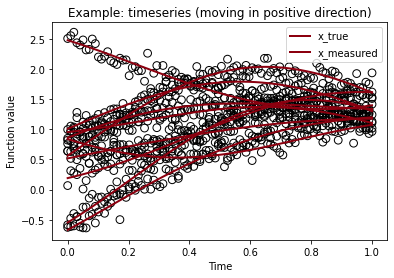

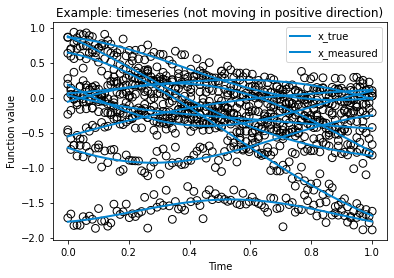

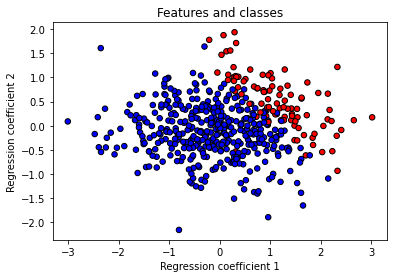

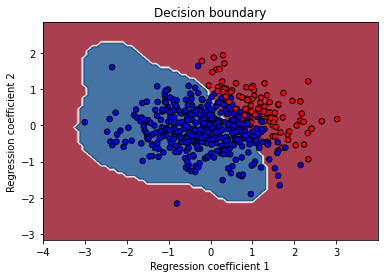

In [7]:

# 6.1 Figure showing examples of timeseries that belong to an object that moeves (into the positive direction)
# and timeseries that belong to an object not moving (into the positive direction)

# Get indices of positive and negative examples
index_neg=np.where(labels_true==0)[0]
index_pos=np.where(labels_true==1)[0]

# Get the corresponding timeseries
x_measured_pos=x_measured[:,index_pos]
x_true_pos=x_true[:,index_pos]
x_measured_neg=x_measured[:,index_neg]
x_true_neg=x_true[:,index_neg]

# Plot some negative and some positive examples
plt.figure(1)
plt.plot(time,x_true_pos[:,range(10)],color='xkcd:crimson',linewidth=2)
for k in range(10):
    plt.scatter(time,x_measured_pos[:,k],s=60, facecolors='none', edgecolors='k')
plt.legend(['x_true','x_measured'])
plt.xlabel('Time')
plt.ylabel('Function value')
plt.title('Example: timeseries (moving in positive direction)')

plt.figure(2)
plt.plot(time,x_true_neg[:,range(10)],color='xkcd:cerulean',linewidth=2)
for k in range(10):
    plt.scatter(time,x_measured_neg[:,k],s=60, facecolors='none', edgecolors='k')
plt.legend(['x_true','x_measured'])
plt.xlabel('Time')
plt.ylabel('Function value')
plt.title('Example: timeseries (not moving in positive direction)')

# 6.2 Figure showing the features associated to the timeseries
plt.figure(3)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(coeffs_estimated[:,0].reshape(-1), coeffs_estimated[:,1].reshape(-1), c=gt_labels.reshape(-1), cmap=cm_bright, s=30, edgecolors='k')
plt.xlabel('Regression coefficient 1')
plt.ylabel('Regression coefficient 2')
plt.title('Features and classes')

# 6.3 Figure showing the decision boundary distinguishing failure from non-failure cases

# Plot differently depending on dimensionality of the features
if coeffs_estimated.shape[1] == 2:
    
    # Create meshgrid on which to evaluate the predictions
    xx_1, xx_2 = make_meshgrid(coeffs_estimated[:,0], coeffs_estimated[:,1],h=0.1)
    X_plot = np.c_[xx_1.ravel(), xx_2.ravel()]
    y_plot = predict(X_plot, lagr_multipliers, support_vector_labels, support_vectors, intercept)
    y_plot = y_plot.reshape(xx_1.shape)

    # Plot the decision boundary.
    plt.figure()
    plt.contourf(xx_1, xx_2, y_plot, cmap=plt.cm.RdBu,alpha=0.8)
    plt.scatter(coeffs_estimated[:,0].reshape(-1), coeffs_estimated[:,1].reshape(-1), c=gt_labels.reshape(-1), cmap=cm_bright, s=30, edgecolors='k')
    plt.xlabel('Regression coefficient 1')
    plt.ylabel('Regression coefficient 2')
    plt.title('Decision boundary')


elif coeffs_estimated.shape[1] == 3:
    
    # Create meshgrid on which to evaluate the predictions
    xx_1, xx_2,xx_3 = make_meshgrid3(coeffs_estimated[:, 0], coeffs_estimated[:, 1],coeffs_estimated[:, 2], h=0.3)

    X_plot = np.c_[xx_1.ravel(), xx_2.ravel(), xx_3.ravel()]
    y_plot = predict(X_plot, lagr_multipliers, support_vector_labels, support_vectors, intercept)
    y_plot = y_plot.reshape(xx_1.shape)

    # Create a figure with axes for 3D plotting
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    fig.suptitle("Classes and features in 3D")

    # Plot the different input points using 3D scatter plotting
    b1 = ax.scatter(coeffs_estimated[:, 0].reshape(-1), coeffs_estimated[:, 1].reshape(-1), coeffs_estimated[:, 2].reshape(-1), c=gt_labels.reshape(-1),
                cmap=plt.cm.coolwarm, s=30, edgecolors='k')
    